# Transients Analysis
### Notebook for automated analysis of woodwind note transients
**read audio files recorded using audacity**
- channel 1 : external audio from Rode NT3 condenser mic
- channel 2 : internal audio from 1/4" B&K pressure mic
- channel 3 : modulated light signal from key displacement photosensor

**obtain matching audio clips and key displacement curves**
- using amplitude trace of light signal

**align signals from multiple transitions for visual comparison**
- *arbitrary*: need to introduce preferred alignment parameters
- can expand on to automate comparison/analysis

**analyze transition duration and time domain info**
- obtain single-cycle periods from internal audio

### General Observations
- Beating effect in external channel for some transitions, f = 62Hz
- Some slower oscillations in internal channel at 2.5Hz in F\#4 note --- see 4750rpm rec 2
- Transition type 1 from D4 to F\#4 --- fundamental freqs. D4 = ca. 300Hz, F\#4 = ca. 376Hz (not much change for rpm range)
- Transition to second note (new freq) happens within 1 or 2 cycles at small key openings
- Pulses on some faster transitions, amplitude rises and then decays back exponentially, possibly due to key-injected pulse
- Key opening transitions more consistent, always display >50% loss of power at small key openings
- Test hypothesis that not-very-open state causes the most loss, and therefore the opening transitions show sharp decreases in amplitude (most time spent in NVO) where closing transitions do not (least time spent in NVO, most in NVC) -- see http://newt.phys.unsw.edu.au/jw/reprints/AlmeidaetalJASA09.pdf#c10

In [1]:
import audacity as au
import numpy as np
import scipy.io.wavfile as wf
import scipy.signal as sig
import matplotlib.pyplot as plt
import peakutils
%matplotlib notebook

In [2]:
### Instrument specs [SI]

# Distance from chimney to open key lip
d_k = 0.0036

# Chimney diameter
d_c = 0.0139

# Bore diameter
d_b = 0.0186

In [3]:
### Extracting channel data

rpm = 4500
rec = 2

auf = au.Aup('%drpm/flute_hybrid_rec%d.aup' %(rpm, rec))
sr = auf.rate
ch1 = auf.get_channel_data(0)
ch2 = auf.get_channel_data(1)
ch3 = auf.get_channel_data(2)

In [4]:
### Functions - Andre

def RMSWind(x, sr=1, nwind=1024, nhop=512, windfunc=np.blackman):
    '''
    Calculates the RMS amplitude amplitude of x, in frames of
    length nwind, and in steps of nhop. windfunc is used as
    windowing function.
    nwind should be at least 3 periods if the signal is periodic.
    '''

    nsam = len(x)
    ist = 0
    iend = ist+nwind

    t = []
    ret = []

    wind = windfunc(nwind)
    wsum2 = np.sum(wind**2)

    while (iend < nsam):
        thisx = x[ist:iend]
        xw = thisx*wind

        ret.append(np.sum(xw*xw/wsum2))
        t.append(float(ist+iend)/2.0/float(sr))

        ist = ist+nhop
        iend = ist+nwind

    return np.sqrt(np.array(ret)), np.array(t)

In [5]:
### Functions - Leon

def key_calib(key, calib):
    '''
    Calibrates key displacement curve `key` by using 
    known distance from chimney to open key lip `calib`.
    Uses mean of both key-open and key-closed values
    to calculate SI unit conversion.
    '''
    key_m = np.median(key)
    key_sort = np.sort(key)
    key_open = np.mean([ key_sort[i] for i in range(len(key))
                        if key_sort[i] <= key_m ])
    key_clsd = np.mean([ key_sort[i] for i in range(len(key))
                        if key_sort[i] > key_m ])
    conversion = calib/(key_clsd-key_open)
    key_SI = key*conversion
    return key_SI

def transition_info(key, tvals, ktype='c'):
    '''
    Selects transition times from timestamp array `t`
    based on max changes in key displacement curve `key`.
    Returns tuple of velocity and time values for
    selected transitions. Use `ktype='o'` to change
    output type from key-closing to key-opening transitions.
    '''
    ktypes = ['c', 'o']
    del_x = np.gradient(key)
    del_t = np.gradient(tvals)
    v = del_x/del_t
    vabs = np.abs(v)
    
    if t[-1] <= 90.0:
        v_peaks = peakutils.indexes(
            vabs, thres=np.max(vabs)/25, min_dist=len(v)/50)
    else:
        v_peaks = peakutils.indexes(
            vabs, thres=np.max(vabs)/25, min_dist=len(v)/65)
    
    v_peakvals = []
    t_peakvals = []
    if ktype=='c':
        v_peakvals = [ v[i] for i in v_peaks if v[i] > 0]
        t_peakvals = [ tvals[i] for i in v_peaks if v[i] > 0]
    elif ktype=='o':
        v_peakvals = [ v[i] for i in v_peaks if v[i] < 0]
        t_peakvals = [ tvals[i] for i in v_peaks if v[i] < 0]
    else:
        raise ValueError(
            "Invalid output type. Expected one of: %s" % ktypes)
    return v_peakvals, t_peakvals

def transition_times(tvals, sr, tpeaks, pre=0.2, post=0.4, opt='audio'):
    '''
    Determines time indices of beginnings and endings of
    transition clips for either audio or key displacement tracks.
    [NOT TESTED]
    '''
    start = np.empty(len(tpeaks))
    end = np.empty(len(tpeaks))
    
    if opt=='audio':
        for i, tpk in enumerate(tpeaks):
            start[i] = int(np.around((tpk-pre)*sr))
            end[i] = int(np.around((tpk+post)*sr))
    elif opt=='key':
        for i, tpk in enumerate(tpeaks):
            start[i] = np.where(tvals==tpk)[0][0]-int(pre*(len(t)/t[-1]))
            end[i] = np.where(tvals==tpk)[0][0]+int(post*(len(t)/t[-1]))
    return start, end

def transition_clips(chdata, start, end, vpeaks, vsep=True, vcrit=0.5):
    '''
    Slices transition clips from audio or key data stored in numpy array.
    [NOT TESTED]
    '''
    fastclips = []
    slowclips = []
    allclips = []
    
    start = start.astype(int)
    end = end.astype(int)
    if len(start)!=len(end)!=len(vpeaks):
        raise ValueError(
            """Invalid input. Arrays `tstart, tend, vpeaks`
            should have equal lengths but instead have lengths
            %d, %d and %d""" % (len(start), len(end), len(vpeaks)))
    elif np.min(vpeaks) > vcrit > np.max(vpeaks):
        raise ValueError(
            "Invalid velocity threshold: `vcrit` is outside of max peak range")
    
    for i, pk in enumerate(vpeaks):
        if vsep==True:
            if pk > vcrit:
                fastclips.append(chdata[start[i] : end[i]])
            elif pk <= vcrit:
                slowclips.append(chdata[start[i] : end[i]])
            return fastclips, slowclips
        else:
            allclips.append(chdata[start[i] : end[i]])
            return allclips

In [15]:
### Data processing

# Obtaining key displacement curve
b, a = sig.butter(4, 1000/sr, 'high')
lightsig = sig.filtfilt(b,a,ch3, padtype='constant')

rms, t=RMSWind(lightsig,sr=sr,nwind=16,nhop=20)
key = rms*np.sqrt(2)

key_SI = key_calib(key, d_k)

# Alligning on peak velocities
v_closing, t_closing = transition_info(key_SI, t)
v_opening, t_opening = transition_info(key_SI, t, ktype='o')

ca_start, ca_end = transition_times(t, sr, t_closing)
ck_start, ck_end = transition_times(t, sr, t_closing, opt='key')
oa_start, oa_end = transition_times(t, sr, t_opening)
ok_start, ok_end = transition_times(t, sr, t_opening, opt='key')

# Obtaining transition clips
audio_fast, audio_slow = transition_clips(ch2, ca_start, ca_end, v_closing)
key_fast, key_slow = transition_clips(ch3, ck_start, ck_end, v_closing)
audio_opening = transition_clips(ch2, oa_start, oa_end, v_opening, vsep=False)
key_opening = transition_clips(ch3, ok_start, ok_end, v_opening, vsep=False)

In [16]:
len(audio_opening), len(key_opening)

(1, 1)

<IPython.core.display.Javascript object>


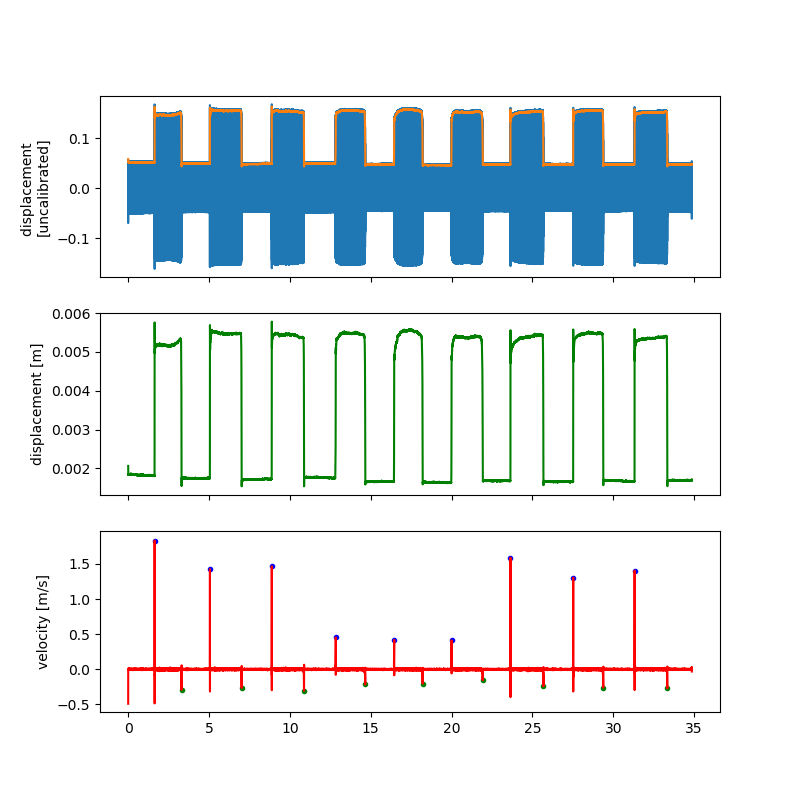

In [7]:
### Visual analysis of key displacement

delx = np.gradient(key_SI)
delt = np.gradient(t)
v_SI = delx/delt

fig,ax = plt.subplots(3,sharex=True,figsize=(8,8))
fig.set_label('keysignal')

ax[0].plot(np.arange(len(lightsig))/sr, lightsig)
ax[0].plot(t, key)
ax[0].set_ylabel('displacement \n[uncalibrated]')

ax[1].plot(t, key_SI, 'g')
ax[1].set_ylabel('displacement [m]')

ax[2].plot(t, v_SI, 'r')
ax[2].set_ylabel('velocity [m/s]')
ax[2].scatter(t_closing, v_closing, c='b', marker='.')
ax[2].scatter(t_opening, v_opening, c='g', marker='.')

<IPython.core.display.Javascript object>


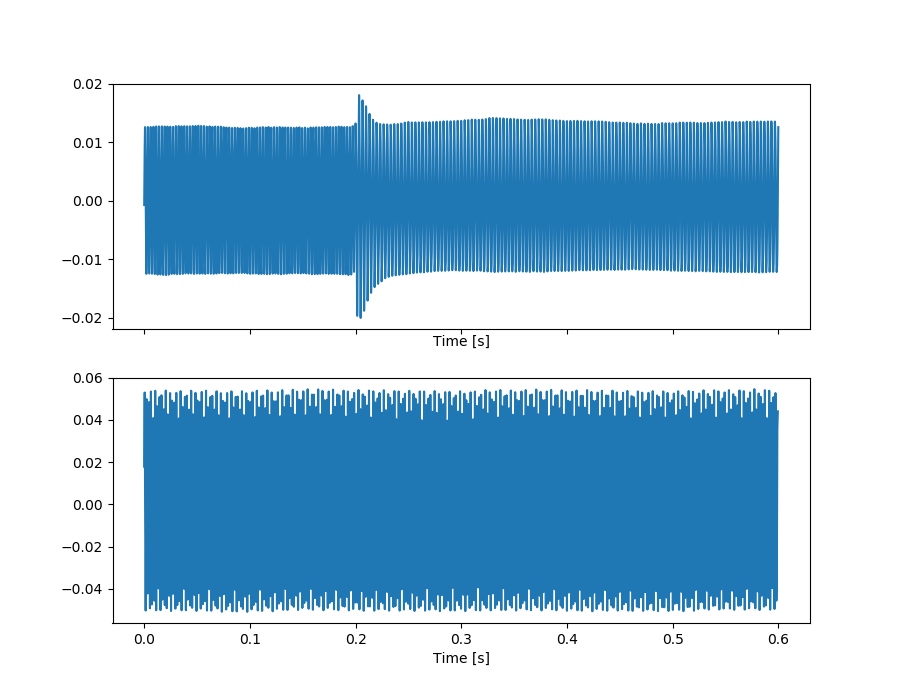

In [11]:
### Visual comparison of transitions

t_sr = len(t)/t[-1]

fig,ax = plt.subplots(2, sharex=True, figsize=(9,7))
fig.set_label('Fast transitions')

for i, audioclip in enumerate(audio_fast):
    x_time = np.arange(len(audioclip))/sr
    ax[0].plot(x_time, audioclip)
    ax[0].set_xlabel('Time [s]')
    
for j, keyclip in enumerate(key_fast):
    x_time = np.arange(len(keyclip))/t_sr
    ax[1].plot(x_time, keyclip)
    ax[1].set_xlabel('Time [s]')

In [28]:
# def align(audio, keysig, t, sr, opt):
    
#     keyfast = []
#     keyslow = []
#     keyopen = []
    
#     fast = []
#     slow = []
#     opening = []
    
#     del_x = np.gradient(keysig)
#     del_t = np.gradient(t)
#     v = del_x/del_t
    
#     if t[-1] <= 90.0:
#         v_peaks = peakutils.indexes(np.abs(v_SI), thres=np.max(np.abs(v_SI))/25, min_dist=len(v_SI)/50)
#     else:
#         v_peaks = peakutils.indexes(np.abs(v_SI), thres=np.max(np.abs(v_SI))/25, min_dist=len(v_SI)/65)
    
#     v_maxvals = [ v[i] for i in v_peaks if v[i] > 0 ]
#     v_minvals = [ v[j] for j in v_peaks if v[j] < 0 ]
#     t_maxvals = [ t[i] for i in v_peaks if v[i] > 0 ]
#     t_minvals = [ t[i] for i in v_peaks if v[j] < 0 ]

#     for i in range(len(v_maxpeaks)):
#         audio_start = int(np.around(t_maxvals[i]*sr))-int(0.1*sr)
#         audio_end = int(np.around(t_maxvals[i]*sr))+int(0.4*sr)
#         key_start = v_maxpeaks[i]-int(0.1*(len(t)/t[-1]))
#         key_end = v_maxpeaks[i]+int(0.4*len(t)/t[-1])
        
#         if v_maxvals[i] < 0.3:
#             slow.append(audio[audio_start : audio_end])
#             keyslow.append(keysig[key_start : key_end])
#         if v_maxvals[i] > 0.3:
#             fast.append(audio[audio_start : audio_end])
#             keyfast.append(keysig[key_start : key_end])
        
#     for j in range(len(v_minpeaks)):
#         audio_start = int(np.around(t_minvals[i]*sr))-int(0.25*sr)
#         audio_end = int(np.around(t_minvals[i]*sr))+int(0.25*sr)
#         key_start = v_minpeaks[i]-int(0.25*(len(t)/t[-1]))
#         key_end = v_minpeaks[i]+int(0.25*len(t)/t[-1])
        
#         opening.append(audio[audio_start : audio_end])
#         keyopen.append(keysig[key_start : key_end])
    
#     if opt=='audio':
#         return fast, slow, opening
# #         F = fast
# #         S = slow
# #         O = opening
# #         return F, S, O
#     if opt=='key':
#         return keyfast, keyslow, keyopen
# #         F = keyfast
# #         S = keyslow
# #         O = keyopen
# #         return F, S, O

In [29]:
# clips = align(w2, key_SI, t, sr, 'audio')
# motion = align(w2, key_SI, t, sr, 'key')

# a_fast = clips[0]
# a_slow = clips[1]
# a_open = clips[2]
# k_fast = motion[0]
# k_slow = motion[1]
# k_open = motion[2]

# # fast = align(w2, key_SI, t, sr, 'audio')
# # slow = align(w2, key_SI, t, sr, 'audio')
# # opening = align(w2, key_SI, t, sr, 'audio')

# # keyfast = align(w2, key_SI, t, sr, 'key')
# # keyslow = align(w2, key_SI, t, sr, 'key')
# # keyopen = align(w2, key_SI, t, sr, 'key')

# len(a_fast), len(a_slow), len(a_open)

In [30]:
# def phasesync(audioclips, keysigs, sr):
#     a_times = []
#     k_times = []
    
#     for i in range(len(audioclips)):
#         clip = audioclips[i]
#         keyclip = keysigs[i]
#         reverse = clip[::-1]
#         last_min = (sig.argrelmin(reverse)[0][0])/sr
# #         last_max = (sig.argrelmax(reverse)[0][0])/sr
#         a_times.append([np.arange(len(clip))/sr + last_min])
#         k_times.append([np.arange(len(keyclip))*(1/2206) + last_min])
        
#     return a_times, k_times

# t_fast = phasesync(a_fast, k_fast, sr)
# t_slow = phasesync(a_slow, k_slow, sr)
# t_open = phasesync(a_open, k_open, sr)

<IPython.core.display.Javascript object>


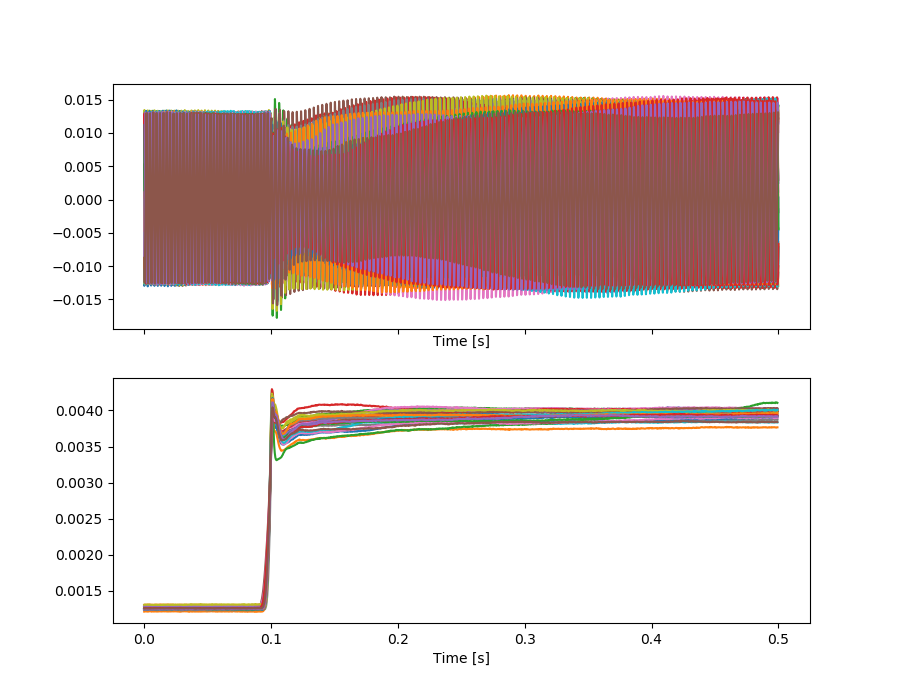

In [44]:
fig,ax = plt.subplots(2, sharex=True, figsize=(9,7))
fig.set_label('Fast transitions')

t_sr = len(t)/t[-1]
for i in range(len(k_fast)):
#     ax[0].plot(t_fast[0][i][0], a_fast[i])
    ax[0].plot(np.arange(len(a_fast[i]))/sr, a_fast[i])
    ax[0].set_xlabel('Time [s]')
#     ax[1].plot(t_fast[1][i][0], k_fast[i])
    ax[1].plot(np.arange(len(k_fast[i]))/t_sr, k_fast[i])
    ax[1].set_xlabel('Time [s]')
#     ax[0].plot(np.arange(len(a_fast[1]))/sr, a_fast[1]/0.000013967527449131013)
#     ax[1].plot(np.arange(len(k_fast[1]))*t_units, k_fast[1]*0.023091481474031384)

<IPython.core.display.Javascript object>


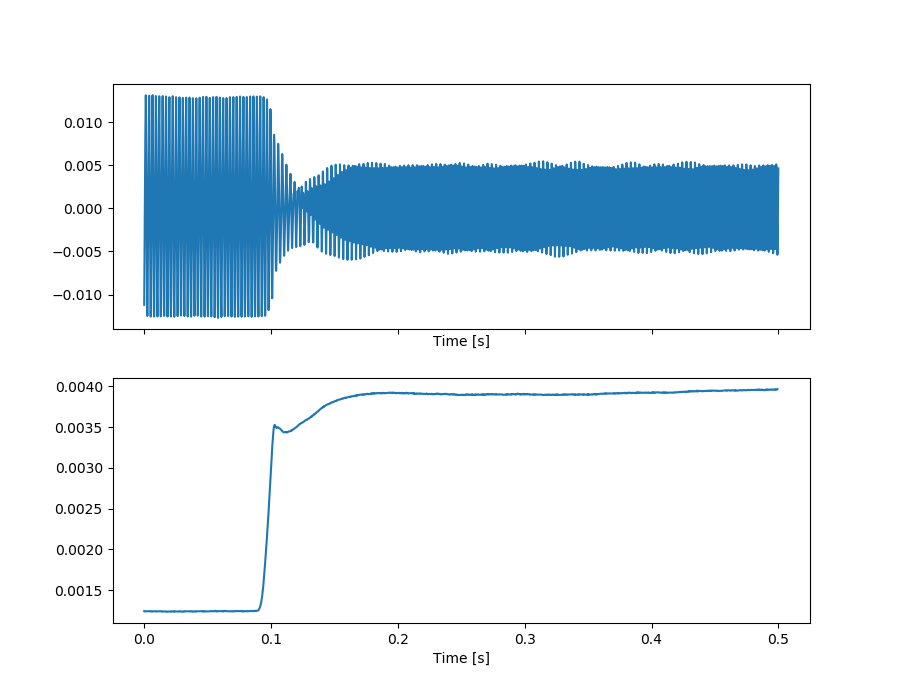

In [45]:
fig,ax = plt.subplots(2, sharex=True, figsize=(9,7))
fig.set_label('Slow transitions')

t_sr = len(t)/t[-1]
for i in range(len(k_slow)):
#     ax[0].plot(t_slow[0][i][0], a_slow[i])
    ax[0].plot(np.arange(len(a_slow[i]))/sr, a_slow[i])
    ax[0].set_xlabel('Time [s]')
#     ax[1].plot(t_slow[1][i][0], k_slow[i])
    ax[1].plot(np.arange(len(k_slow[i]))/t_sr, k_slow[i])
    ax[1].set_xlabel('Time [s]')

<IPython.core.display.Javascript object>


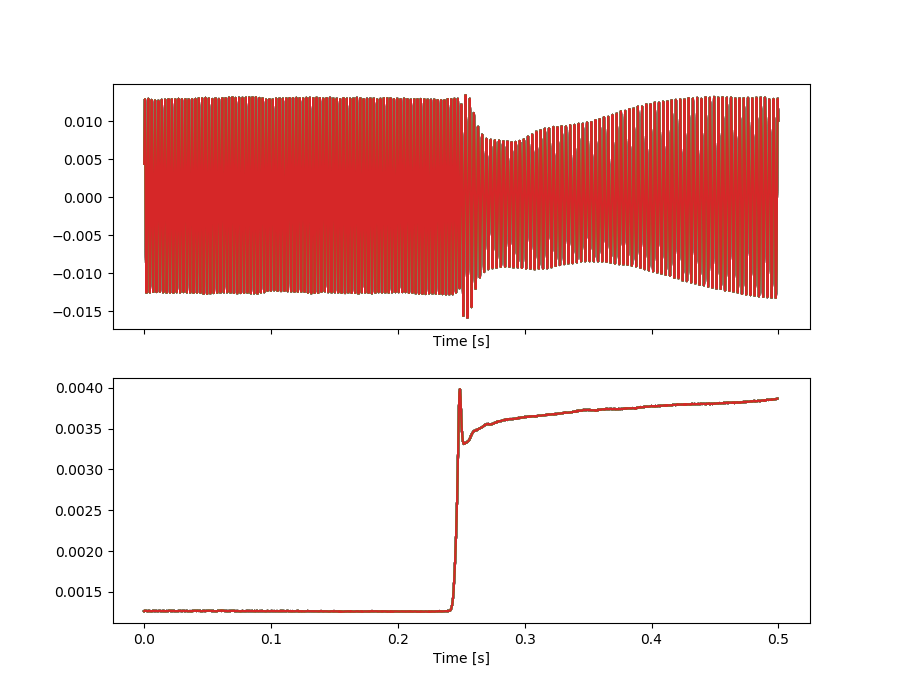

In [38]:
fig,ax = plt.subplots(2, sharex=True, figsize=(9,7))
fig.set_label('Opening transitions')

t_sr = len(t)/t[-1]
for j in range(len(k_open)):
#     ax[0].plot(t_open[0][j][0], a_open[j])
    ax[0].plot(np.arange(len(a_open[j]))/sr, a_open[j])
    ax[0].set_xlabel('Time [s]')
#     ax[1].plot(t_open[1][j][0], k_open[j])
    ax[1].plot(np.arange(len(k_open[j]))/t_sr, k_open[j])
    ax[1].set_xlabel('Time [s]')